<a href="https://colab.research.google.com/github/schauppi/Tensorflow/blob/schauppi/Siamese_Neural_Network/Siamese_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist

In [31]:
input_image_shape = (28,28,1)

In [32]:
def build_siamese_model(inputShape, embeddingDim=48):
  inputs = keras.layers.Input(inputShape)

  x = keras.layers.Conv2D(64, (2,2), padding="same", activation="relu")(inputs)
  x = keras.layers.MaxPool2D(2,2)(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Conv2D(64, (2,2), padding="same", activation="relu")(x)
  x = keras.layers.MaxPool2D(2,2)(x)
  x = keras.layers.Dropout(0.2)(x)

  pooledOutput = keras.layers.GlobalAveragePooling2D()(x)
  outputs = keras.layers.Dense(embeddingDim)(pooledOutput)

  model = keras.models.Model(inputs, outputs)

  return model

In [33]:
def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []
	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
	# loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]
		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])
		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])
	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

In [34]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [44]:
def plot_training(H):
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")

In [36]:
#load and prepare the data
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0

In [37]:
#expand dimension
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

In [38]:
#positive and negative pairs
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

In [39]:
#build the network
imgA = keras.layers.Input(shape=input_image_shape)
imgB = keras.layers.Input(shape=input_image_shape)

featureExtractor = build_siamese_model(input_image_shape)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [40]:
distance = keras.layers.Lambda(euclidean_distance)([featsA, featsB])
outputs = keras.layers.Dense(1, activation="sigmoid")(distance)
model = keras.models.Model(inputs=[imgA, imgB], outputs=outputs)

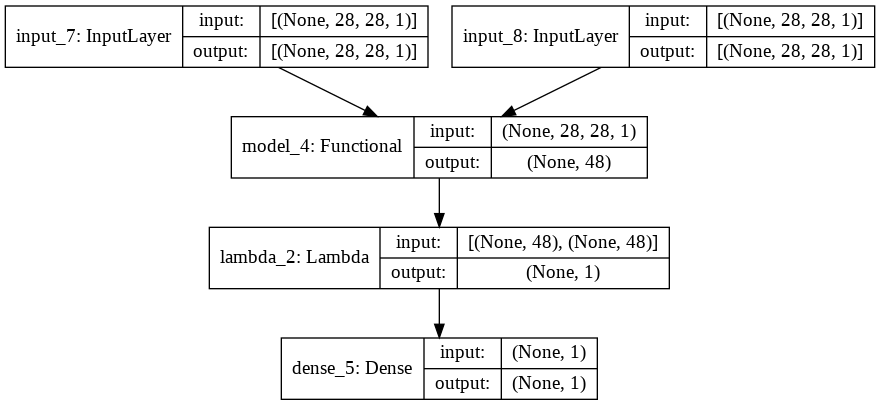

In [41]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [42]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [43]:
history = model.fit([pairTrain[:,0], pairTrain[:,1]], labelTrain[:],
                    validation_data=([pairTest[:,0], pairTest[:, 1]], labelTest[:]),
                    batch_size = 64, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 28s 14ms/step - loss: 0.6397 - accuracy: 0.6025 - val_loss: 0.5289 - val_accuracy: 0.7600
Epoch 2/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.5331 - accuracy: 0.7442 - val_loss: 0.4529 - val_accuracy: 0.8038
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.4713 - accuracy: 0.7823 - val_loss: 0.4119 - val_accuracy: 0.8225
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.4407 - accuracy: 0.7975 - val_loss: 0.3781 - val_accuracy: 0.8390
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.4156 - accuracy: 0.8133 - val_loss: 0.3508 - val_accuracy: 0.8544
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.3950 - accuracy: 0.8258 - val_loss: 0.3325 - val_accuracy: 0.8613
Epoch 7/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3837 - accuracy: 0.8311 - val_loss: 0.3290 -

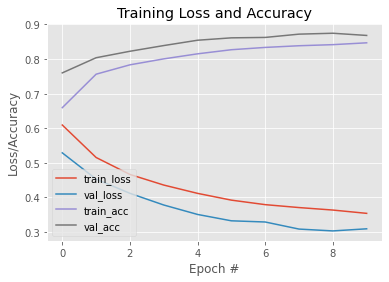

In [45]:
plot_training(history)